# Block vs non-block, normalisation vs non-normalisation - One Dimensional analysis, using user RL code and experimental LM data

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import tifffile

In [3]:
exp_data_3d = tifffile.imread('../testdata/data.tif')

In [4]:
exp_data_3d.shape

(60, 1026, 1544)

In [5]:
data = exp_data_3d[30,513,:]

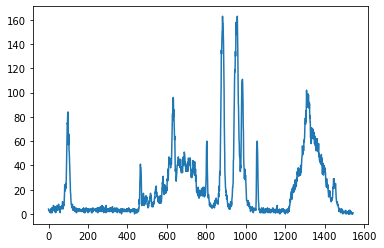

In [6]:
plt.plot(data)

In [7]:
data.shape

(1544,)

## Create a cropped region

In [23]:
x_crop_0, x_crop_1 = 400 , 1000
data_crop = data[x_crop_0:x_crop_1]

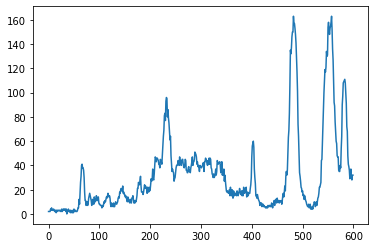

In [31]:
plt.plot(data_crop)

## Some psf

In [77]:
#gaussian psf for testing
w_psf = 16
w_psf_half = int(w_psf/2)

x_psf = np.linspace(-w_psf_half, + w_psf_half,w_psf)
gauss1d = np.exp( -np.multiply(x_psf,x_psf)/ w_psf )
psf_test = gauss1d / gauss1d.sum()

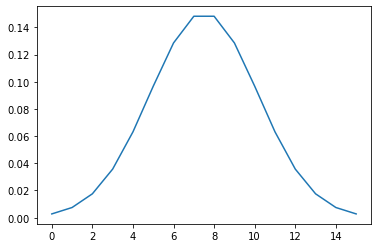

In [78]:
plt.plot(psf_test)

## RL deconvolution, user code

In [79]:
def RL0(data, psf, niter, do_edge_norm=True):
    #print("data.shape :",data.shape)
    #print("psf shape :", psf.shape)
    #Uses normalisation of data for extended size

    #Check data is one dim
    if data.ndim!= 1 and psf.ndim!=1:
        print ("Error: data and/or psf are not 1D. Returning None")
        return None
    
    # #Make sure data shape is even by cropping extra if needed
    # if data.shape[0] % 2 != 0 :
    #     data = data[:-1]
    #     print("new data.shape :",data.shape)

    #make sure psf is normalised sum
    psf0 = psf/ psf.sum()

    #Create a psf-like array that will be used to resize data
    delta_arr = np.zeros_like(psf0)
    phw = int(psf0.shape[0]/2) #Half-width of the psf
    delta_arr[ phw ] = 1.0
    data_shaped = np.convolve(data, delta_arr, mode='full')
    #print("data_shaped shape:", data_shaped.shape)

    #Create a normalisation array
    # a technique that helps slowing the reduction of edge effects with growing niter
    onesarray = np.ones_like(data)
    normarray = np.convolve(onesarray, psf0,mode='full')

    psf0_flip = np.flip(psf0)

    xn1 = np.array(data) #Initialise copy

    for i in range(niter):
        #print("iteration: ", i)
        xn=xn1
        #Convolution at denominator
        u0 = np.convolve(xn, psf0, mode='full')
        #print("u0 shape:", u0.shape)

        #Division
        div0 = data_shaped / u0 #TODO: check sizes are compatible

        #Convolve the result with flipped psf
        u2 = np.convolve(div0,psf0_flip, mode='same') #Use same setting to crop result
        #print("u2 shape:", u2.shape)

        #Multiplication with previous estimation
        #mult0 = np.multiply(xn, u2) #Error in sizes, should use extended previous estimation
        xn_ext = np.convolve(xn, delta_arr, mode='full')
        #print("xn_ext shape:", xn_ext.shape)

        mult0 = np.multiply(xn_ext,u2)

        norm0 = None
        #Optionally divide with normalisation array
        if do_edge_norm==True:
            norm0 = np.divide(mult0, normarray)
        else:
            norm0= mult0

        #crop result
        xn1 = norm0[phw:-phw+1]
        #print("xn1 shape:", xn1.shape)

    res = xn1

    return res

In [80]:
#Test
niter=10
deconv_RL0 = RL0(data,psf_test, niter)

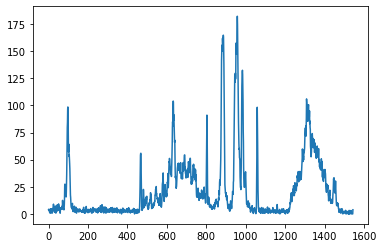

In [81]:
plt.plot(deconv_RL0)

Calculate RL in cropped section of data

In [82]:
deconv_RL0_crop = RL0(data_crop,psf_test, niter)

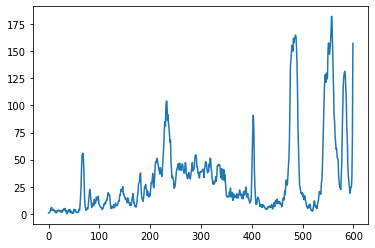

In [83]:
plt.plot(deconv_RL0_crop)

Compare results

In [84]:
deconv_RL0.shape

(1544,)

In [85]:
deconv_RL0[x_crop_0:x_crop_1].shape

(600,)

In [86]:
deconv_RL0_crop.shape

(600,)

In [87]:
diffsq = np.power(deconv_RL0_crop-deconv_RL0[x_crop_0:x_crop_1], 2)

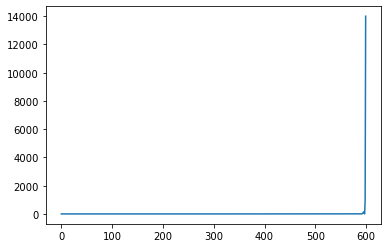

In [88]:
plt.plot(diffsq)

In [89]:
diffsq_valid = diffsq < 1e-12

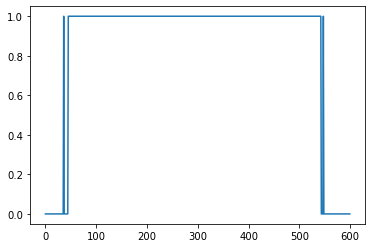

In [90]:
plt.plot(diffsq_valid)

In [91]:
#Get maximum width
def get_max_width(data1d, valcond = 1):
    maxwidth0=0
    width0=0
    for i in range(data1d.shape[0]):
        v0 = data1d[i]
        if v0==valcond:
            width0+=1
        else:
            width0==0
        maxwidth0 = max(maxwidth0,width0)
    return maxwidth0

In [92]:
get_max_width(diffsq_valid)

500

## max_valid_width vs niter and psf size

In [93]:
from scipy import signal
from numpy.random import default_rng
def crop_vs_noncrop_RL_diff_get_valid_max_width_vs_iter_and_psfsize(data, x_crop_0=100, x_crop_1=350, niter0=20, psf_half_width0=8):

    #Get maximum width
    def _get_max_width(data1d):
        maxwidth0=0
        width0=0
        for i in range(data1d.shape[0]):
            v0 = data1d[i]
            if v0==1:
                width0+=1
            else:
                width0==0
            maxwidth0 = max(maxwidth0,width0)
        return maxwidth0

    #create gaussian psf with given width
    psf_width0 = 2*psf_half_width0

    x_psf0 = np.linspace(-psf_half_width0, + psf_half_width0,psf_width0)
    gauss1d0 = np.exp( -np.multiply(x_psf0,x_psf0) / psf_half_width0 )
    psf_norm0 = gauss1d0 / gauss1d0.sum()

    #x_crop_0, x_crop_1 = 100 , 350
    data_crop0 = data[x_crop_0:x_crop_1]

    #RL deconvolution on the original data and in the cropped data
    deconv_skimageRL0 = RL0(data,psf_norm0, niter0)
    deconv_skimageRL_crop0 = RL0(data_crop0,psf_norm0, niter0)

    #Get difference and max_width
    diffsq0 = np.power( deconv_skimageRL_crop0 - deconv_skimageRL0[x_crop_0:x_crop_1 ], 2)
    diffsq_valid0 = diffsq0 < 1e-12
    m0 = _get_max_width(diffsq_valid0)
    return m0

In [94]:
#test
crop_vs_noncrop_RL_diff_get_valid_max_width_vs_iter_and_psfsize(data, 400, 1000 , 1, )

573

ok

Firt, study max_valid_width vs niter

In [95]:
niter_range = np.arange(2,100)
maxwidths_vs_niter = []
for niter0 in niter_range:
    maxwidth = crop_vs_noncrop_RL_diff_get_valid_max_width_vs_iter_and_psfsize(data, 400,1000, niter0)
    print("niter0: ", niter0 , ", maxwidth:", maxwidth)
    maxwidths_vs_niter.append( (niter0,maxwidth) )

niter0:  2 , maxwidth: 562
niter0:  3 , maxwidth: 553
niter0:  4 , maxwidth: 545
niter0:  5 , maxwidth: 540
niter0:  6 , maxwidth: 537
niter0:  7 , maxwidth: 531
niter0:  8 , maxwidth: 531
niter0:  9 , maxwidth: 527
niter0:  10 , maxwidth: 526
niter0:  11 , maxwidth: 524
niter0:  12 , maxwidth: 523
niter0:  13 , maxwidth: 522
niter0:  14 , maxwidth: 524
niter0:  15 , maxwidth: 520
niter0:  16 , maxwidth: 518
niter0:  17 , maxwidth: 520
niter0:  18 , maxwidth: 518
niter0:  19 , maxwidth: 516
niter0:  20 , maxwidth: 516
niter0:  21 , maxwidth: 516
niter0:  22 , maxwidth: 514
niter0:  23 , maxwidth: 512
niter0:  24 , maxwidth: 511
niter0:  25 , maxwidth: 512
niter0:  26 , maxwidth: 511
niter0:  27 , maxwidth: 511
niter0:  28 , maxwidth: 509
niter0:  29 , maxwidth: 510
niter0:  30 , maxwidth: 511
niter0:  31 , maxwidth: 512
niter0:  32 , maxwidth: 511
niter0:  33 , maxwidth: 507
niter0:  34 , maxwidth: 506
niter0:  35 , maxwidth: 506
niter0:  36 , maxwidth: 505
niter0:  37 , maxwidth: 506


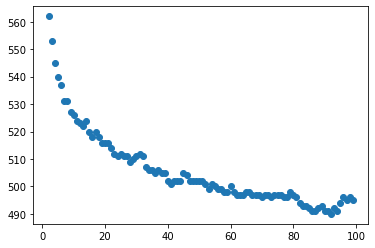

In [96]:
plt.scatter(*zip(*maxwidths_vs_niter))

Plot shows that valid region in a cropped block after the RL deconvolution drops with the number of RL iterations in an exponential way.

When doing block deconvolution, this may need to be taken into account.

It remains to see how the psf size also affects the padding region needed to be considered

Try to fit an exponential or 1/x ?

In [97]:
maxwidths_np = np.array(maxwidths_vs_niter)
maxwidths_np

array([[  2, 562],
       [  3, 553],
       [  4, 545],
       [  5, 540],
       [  6, 537],
       [  7, 531],
       [  8, 531],
       [  9, 527],
       [ 10, 526],
       [ 11, 524],
       [ 12, 523],
       [ 13, 522],
       [ 14, 524],
       [ 15, 520],
       [ 16, 518],
       [ 17, 520],
       [ 18, 518],
       [ 19, 516],
       [ 20, 516],
       [ 21, 516],
       [ 22, 514],
       [ 23, 512],
       [ 24, 511],
       [ 25, 512],
       [ 26, 511],
       [ 27, 511],
       [ 28, 509],
       [ 29, 510],
       [ 30, 511],
       [ 31, 512],
       [ 32, 511],
       [ 33, 507],
       [ 34, 506],
       [ 35, 506],
       [ 36, 505],
       [ 37, 506],
       [ 38, 505],
       [ 39, 505],
       [ 40, 502],
       [ 41, 501],
       [ 42, 502],
       [ 43, 502],
       [ 44, 502],
       [ 45, 505],
       [ 46, 504],
       [ 47, 502],
       [ 48, 502],
       [ 49, 502],
       [ 50, 502],
       [ 51, 502],
       [ 52, 501],
       [ 53, 499],
       [ 54,

In [98]:
from scipy.optimize import curve_fit

def exp_func(x,a,b,c):
    return a*np.exp(b*x)+c

def over_x_func(x,a,c):
    return a / x +c

exp_fit_res = curve_fit(exp_func,maxwidths_np[:,0], maxwidths_np[:,1], p0=(200,-1,100))

overx_fit_res = curve_fit(over_x_func,maxwidths_np[:,0], maxwidths_np[:,1] , p0=(1,150))

In [99]:
exp_fit_res

(array([ 5.93983347e+01, -4.90976650e-02,  4.94360726e+02]),
 array([[ 2.10902293e+00, -1.87850462e-03,  4.62930695e-02],
        [-1.87850462e-03,  6.09204446e-06, -1.10013170e-03],
        [ 4.62930695e-02, -1.10013170e-03,  3.35802190e-01]]))

In [100]:
overx_fit_res

(array([180.7453167 , 498.03018957]),
 array([[94.57142985, -4.03123031],
        [-4.03123031,  0.61267222]]))

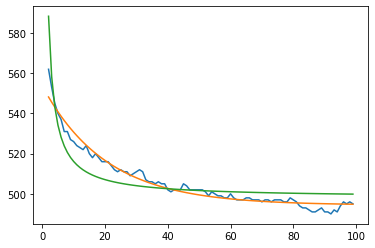

In [101]:
plt.plot( maxwidths_np[:,0], maxwidths_np[:,1])
plt.plot(maxwidths_np[:,0], exp_func(maxwidths_np[:,0], *exp_fit_res[0]))
plt.plot(maxwidths_np[:,0], over_x_func(maxwidths_np[:,0], *overx_fit_res[0]))

Exponential fits better with data

## Get maxwidth as a function of number of iterations and psf size

In [60]:
niter_range = np.arange(2,100)
psf_hwidth_range = np.arange(8,32)

maxwidths_vs_niter_and_psfhwidth = []
for niter0 in niter_range:
    for phw0 in psf_hwidth_range:
        maxwidth = crop_vs_noncrop_RL_diff_get_valid_max_width_vs_iter_and_psfsize(data, 400,1000, niter0, phw0)
        print("niter0: ", niter0 , ", psf_width:", phw0 , ", maxwidth:", maxwidth)
        maxwidths_vs_niter_and_psfhwidth.append( (niter0,phw0,maxwidth) )

niter0:  2 , psf_width: 8 , maxwidth: 562
niter0:  2 , psf_width: 9 , maxwidth: 558
niter0:  2 , psf_width: 10 , maxwidth: 556
niter0:  2 , psf_width: 11 , maxwidth: 554
niter0:  2 , psf_width: 12 , maxwidth: 552
niter0:  2 , psf_width: 13 , maxwidth: 549
niter0:  2 , psf_width: 14 , maxwidth: 548
niter0:  2 , psf_width: 15 , maxwidth: 545
niter0:  2 , psf_width: 16 , maxwidth: 543
niter0:  2 , psf_width: 17 , maxwidth: 541
niter0:  2 , psf_width: 18 , maxwidth: 539
niter0:  2 , psf_width: 19 , maxwidth: 537
niter0:  2 , psf_width: 20 , maxwidth: 535
niter0:  2 , psf_width: 21 , maxwidth: 533
niter0:  2 , psf_width: 22 , maxwidth: 532
niter0:  2 , psf_width: 23 , maxwidth: 530
niter0:  2 , psf_width: 24 , maxwidth: 528
niter0:  2 , psf_width: 25 , maxwidth: 527
niter0:  2 , psf_width: 26 , maxwidth: 524
niter0:  2 , psf_width: 27 , maxwidth: 523
niter0:  2 , psf_width: 28 , maxwidth: 523
niter0:  2 , psf_width: 29 , maxwidth: 522
niter0:  2 , psf_width: 30 , maxwidth: 521
niter0:  2 , 

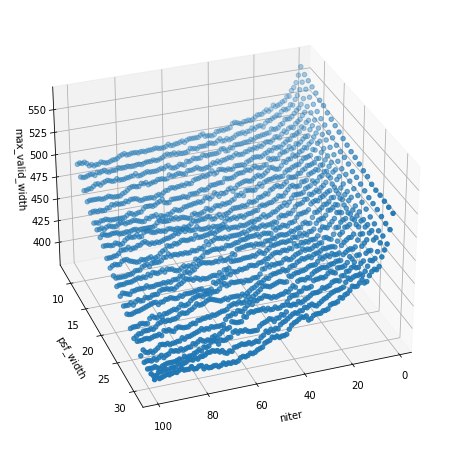

In [61]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(projection='3d', )
ax.scatter(*zip(*maxwidths_vs_niter_and_psfhwidth))
ax.set_xlabel('niter')
ax.set_zlabel('max_valid_width')
ax.set_ylabel('psf_width')
ax.view_init(azim=70)
plt.show()

Increasing PSF width makes valid_width reduce significantly in an apparent linear fashion

In [62]:
psf_hwidth_range = np.arange(8,32)

maxwidths_vs_psfwidth = []
niter0=20 #Fixed number of RL iterations

for phw0 in psf_hwidth_range:
    maxwidth = crop_vs_noncrop_RL_diff_get_valid_max_width_vs_iter_and_psfsize(data, 400,1000, niter0, phw0)
    print("psf_width: ", phw0 , ", maxwidth:", maxwidth, )
    maxwidths_vs_psfwidth.append( (phw0,maxwidth) )

psf_width:  8 , maxwidth: 516
psf_width:  9 , maxwidth: 507
psf_width:  10 , maxwidth: 505
psf_width:  11 , maxwidth: 500
psf_width:  12 , maxwidth: 499
psf_width:  13 , maxwidth: 492
psf_width:  14 , maxwidth: 489
psf_width:  15 , maxwidth: 487
psf_width:  16 , maxwidth: 487
psf_width:  17 , maxwidth: 483
psf_width:  18 , maxwidth: 478
psf_width:  19 , maxwidth: 473
psf_width:  20 , maxwidth: 469
psf_width:  21 , maxwidth: 462
psf_width:  22 , maxwidth: 459
psf_width:  23 , maxwidth: 456
psf_width:  24 , maxwidth: 457
psf_width:  25 , maxwidth: 457
psf_width:  26 , maxwidth: 455
psf_width:  27 , maxwidth: 451
psf_width:  28 , maxwidth: 447
psf_width:  29 , maxwidth: 444
psf_width:  30 , maxwidth: 443
psf_width:  31 , maxwidth: 442


Text(0, 0.5, 'max valid width')

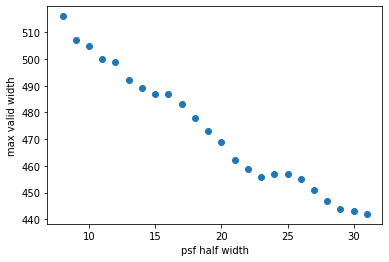

In [63]:
plt.scatter(*zip(*maxwidths_vs_psfwidth))
#plt.axline(*zip(*maxwidths_vs_psfwidth))
plt.xlabel("psf half width")
plt.ylabel("max valid width")

Confirmation that maximum valid width decreases linearly as the psf size increases.

Try to fit a line and get the parameters

In [64]:
maxwidths_vs_psfwidth_np = np.array(maxwidths_vs_psfwidth)
maxwidths = maxwidths_vs_psfwidth_np[:,1]
psfhwidth = maxwidths_vs_psfwidth_np[:,0]

In [65]:
fitparams = np.polyfit(maxwidths, 2*psfhwidth, 1)
fitparams

array([ -0.61565642, 330.35939932])

Interesting, the maxwidth does not reduce by a -1.0*psfwidth .

Try to fit max_width vs niter and psfwidth with a formula

Maybe something like

max_width = -k*phw 

## Compare with theoretical formula of 'valid' region after convolution

Assumning each RL (2 convolutions) leads to a valid size that is smaller than original data given by formula

$ M_n = m + n(2-2p)$

In [72]:
niter_range = np.arange(1,50)
psf_hwidth_range = np.arange(8,32)

maxwidths_vs_niter_and_psfhwidth_RL= []
maxwidths_vs_niter_and_psfhwidth_theory = []

datacrop_width = data_crop.shape[0]

print(f"datacrop_width: {datacrop_width}")

for niter0 in niter_range:
    for phw0 in psf_hwidth_range:
        maxwidth = crop_vs_noncrop_RL_diff_get_valid_max_width_vs_iter_and_psfsize(data, 400,1000, niter0, phw0)
        maxwidths_vs_niter_and_psfhwidth_RL.append( (niter0,phw0,maxwidth) )

        maxwidth_theory = datacrop_width + (niter0+1)*(2-2*phw0)
        if maxwidth_theory>0:
            maxwidths_vs_niter_and_psfhwidth_theory.append((niter0,phw0, maxwidth_theory))

        print("niter0: ", niter0 , ", psf_half_width:", phw0 , ", maxwidth:", maxwidth, " maxwidth_theory:", maxwidth_theory)


datacrop_width: 600
niter0:  1 , psf_half_width: 8 , maxwidth: 573  maxwidth_theory: 572
niter0:  1 , psf_half_width: 9 , maxwidth: 571  maxwidth_theory: 568
niter0:  1 , psf_half_width: 10 , maxwidth: 569  maxwidth_theory: 564
niter0:  1 , psf_half_width: 11 , maxwidth: 568  maxwidth_theory: 560
niter0:  1 , psf_half_width: 12 , maxwidth: 565  maxwidth_theory: 556
niter0:  1 , psf_half_width: 13 , maxwidth: 564  maxwidth_theory: 552
niter0:  1 , psf_half_width: 14 , maxwidth: 562  maxwidth_theory: 548
niter0:  1 , psf_half_width: 15 , maxwidth: 562  maxwidth_theory: 544
niter0:  1 , psf_half_width: 16 , maxwidth: 560  maxwidth_theory: 540
niter0:  1 , psf_half_width: 17 , maxwidth: 558  maxwidth_theory: 536
niter0:  1 , psf_half_width: 18 , maxwidth: 557  maxwidth_theory: 532
niter0:  1 , psf_half_width: 19 , maxwidth: 556  maxwidth_theory: 528
niter0:  1 , psf_half_width: 20 , maxwidth: 555  maxwidth_theory: 524
niter0:  1 , psf_half_width: 21 , maxwidth: 554  maxwidth_theory: 520
ni

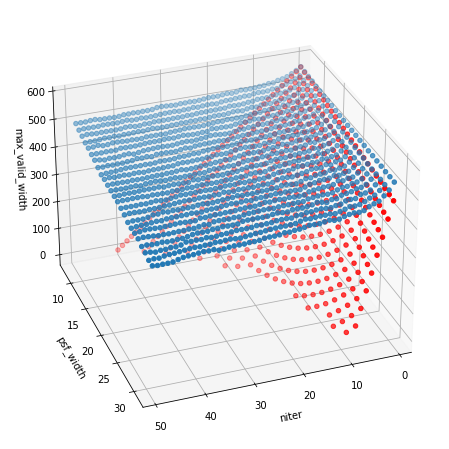

In [73]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(projection='3d', )
ax.scatter(*zip(*maxwidths_vs_niter_and_psfhwidth_RL))
ax.scatter(*zip(*maxwidths_vs_niter_and_psfhwidth_theory), c='red')
ax.set_xlabel('niter')
ax.set_zlabel('max_valid_width')
ax.set_ylabel('psf_width')
ax.view_init(azim=70)
plt.show()